In [ ]:
# in this notebook, the word "sentences" is used instead of "section contents" like in the report

In [1]:
%run ../utils/common.py

In [2]:
article_sections=load_json("../data/article_sections_filtered.json", object_hook=article_sections_object_hook)

# we get the set of article ids which have at least one section after filtering out unique sections
articles_with_sections=set(article_sections.keys())

# while in memory, we use category ids insead of their titles to save space (because the same category appears multiple times)
category_title_to_id_map=get_category_title_to_id_map()
category_id_to_title_map={v:k for k,v in category_title_to_id_map.items()}

In [3]:
wcnoutput_file="../data/gini_articles_scores_0985_no_unknown_type.json"

In [4]:
# key: category, value: articles that contribute to given category's section counts
category_articles={}
with open(wcnoutput_file) as f:
    for line in f:
        line_dict = json.loads(line)
        category = line_dict['category']
        category_id=category_title_to_id_map[category]
        articles=[article for article in line_dict['articles'] if article in articles_with_sections]
        category_articles[category_id]=articles

In [5]:
del articles_with_sections

In [6]:
category_top_sections={category_title_to_id_map[category]:sections for category,sections in json.loads(open("../data/category_top_sections.json").read()).items()}

In [7]:
# key: community, value: categories in this community
community_categories={}
with open("../data/categories_splitted_into_communities.json", "r") as f_in:
    for line in f_in:
        json_line=json.loads(line)
        categories=json_line['categories']
        community_id=json_line['community_id']
        community_categories[community_id]=[category_title_to_id_map[category] for category in categories]

In [8]:
#key: category id, value: community to which this category belongs
category_community={}
for community,categories in community_categories.items():
    for category_id in categories:
        category_community[category_id]=community

In [9]:
#key: article id, value: list of categories to which this article contributes its sections to the section counts
article_category={}
with open("../data/article_categories_no_unknown_types.tsv") as f:
    for line in f:
        split_line = line.split()
        article = int(split_line[0])
        category = split_line[2]
        category_id=category_title_to_id_map[category]
        if article not in article_category.keys():
            article_category[article]=[]
        article_category[article].append(category_id)

In [10]:
# key: article id, value: number of communities in which article appears
article_nb_communities={article:len(set([category_community[category_id] for category_id in article_category[article] if category_id in category_community.keys()])) for article in article_category.keys()}

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def plot_nb_different_category_communities_by_article(article_nb_communities):
    plt.figure(figsize=(14,8))
    
    data=[]
    for article,nb_communities in article_nb_communities.items():
        data.append(nb_communities)
            
    plot=sns.histplot(data=data,stat="probability",bins=list(range(1,11)))
    plot.set_xticks(list(range(1,11)))
    
    plot.set_title("Distribution of number of communities to which articles belong")
    plot.set_xlabel("Number of communities by article")
    plot.set_ylabel("Proportion")
    plt.show()

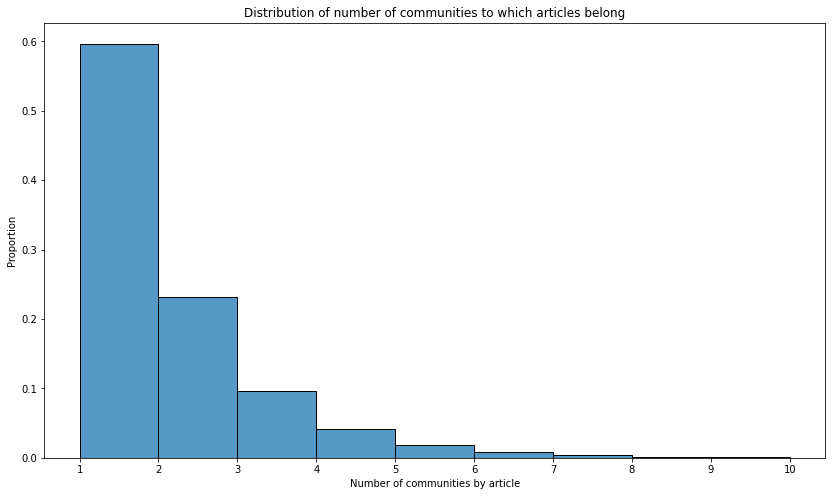

In [14]:
plot_nb_different_category_communities_by_article(article_nb_communities)

In [20]:
community_top_sections={}
community_articles={}

for community_id in tqdm(list(community_categories.keys())):
    community_top_sections[community_id]=set()
    community_articles[community_id]=set()
    
    for category_id in community_categories[community_id]:
        community_top_sections[community_id]|=set(category_top_sections[category_id])
        del category_top_sections[category_id]
        
        community_articles[community_id]|=set(category_articles[category_id])
        del category_articles[category_id]
        
    
    del community_categories[community_id]

  0%|          | 0/28053 [00:00<?, ?it/s]

In [21]:
def get_sum_nb_sentences(community_ids):
    sum_nb_sentences_in_communities=0
    articles=set().union(*[community_articles[community_id] for community_id in community_ids])
    top_sections=set().union(*[community_top_sections[community_id] for community_id in community_ids])
    for article in articles:
        if article in article_sections.keys():
            for section in article_sections[article]:
                if section in top_sections:
                    sum_nb_sentences_in_communities+=1
                
    return sum_nb_sentences_in_communities

In [22]:
# key: community id, value: sum of nb sentences among articles in a community
community_nb_sentences={community_id:get_sum_nb_sentences([community_id]) for community_id in community_articles.keys()}

In [23]:
from collections import Counter
communities_sorted_by_nb_sentences=[community for community,nb_sentences in Counter(community_nb_sentences).most_common()]

In [24]:
decreasing_nb_sentences=[nb_sentences for community,nb_sentences in Counter(community_nb_sentences).most_common()]

In [25]:
decreasing_nb_sentences[:10]

[420863,
 395963,
 385494,
 361622,
 359183,
 344956,
 334873,
 334753,
 331623,
 331594]

In [26]:
len(communities_sorted_by_nb_sentences)

28053

In [27]:
# the goal is to scan the file once for multiple communities, we cannot fit all the section contents at same time
# in this notebook, we use it to measure if the section contents of n communities would fit in memory
def get_article_section_sentences_for_communities(communities):
    articles_to_get=set().union(*[community_articles[x] for x in communities])
    sections_to_get=set().union(*[community_top_sections[x] for x in communities])
    
    article_section_sentences={}
    with open("../data/article_section_grouped_sentences.json", "r") as f_in:
        for line in tqdm(f_in,total=1726525):
            json_line=json.loads(line)
            article_id=json_line['article_id']
            if article_id not in articles_to_get:
                continue
            section_sentences=[section_sentence for section_sentence in json_line['section_grouped_sentences'] if section_sentence['section'] in sections_to_get]
            
            already_added_sections=set()
            section_first_sentences=[]
            for section_sentence in section_sentences:
                del section_sentence['token_count']
                # we use only first grouped section content for each section
                if section_sentence['section'] not in already_added_sections:
                    section_first_sentences.append(section_sentence)
                already_added_sections.add(section_sentence['section'])

            article_section_sentences[article_id]=section_first_sentences
            
    return article_section_sentences

In [28]:
n=10

In [29]:
# different values for n were tested to see how much unique section contents at the same time
# could be loaded in memory
# 69% memory before
# 76% after, with n=10
x=get_article_section_sentences_for_communities(communities_sorted_by_nb_sentences[:n])

  0%|          | 0/1726525 [00:00<?, ?it/s]

In [30]:
del x

In [31]:
max_sum_nb_sentences_by_batch=get_sum_nb_sentences(communities_sorted_by_nb_sentences[:n])

In [32]:
max_sum_nb_sentences_by_batch

2294401

In [33]:
# we group together communities in batches in order to avoid to read the article_section_grouped_sentences
# file for each community
# the first 10 communities of the sorted community list by decreasing nb_sentences order fitted in memory
# therefore the criteria to group together the next communities after the first 10, was the sum of
# the number of sentences in those 10 first communities

beginning_indexes=[]
end_indexes=[]
beginning_index=0
end_index=0

pbar=tqdm(total=len(communities_sorted_by_nb_sentences))
index_multiplier=1
while end_index<len(communities_sorted_by_nb_sentences):
    sum_nb_sentences_by_batch=0
    while True:
        sum_nb_sentences_by_batch=get_sum_nb_sentences(communities_sorted_by_nb_sentences[beginning_index:end_index])
        if sum_nb_sentences_by_batch>=max_sum_nb_sentences_by_batch or end_index>=len(communities_sorted_by_nb_sentences):
            break
        end_index+=10*index_multiplier
        pbar.update(10*index_multiplier)
    
    index_multiplier*=2
    if end_index>len(communities_sorted_by_nb_sentences):
        end_index=len(communities_sorted_by_nb_sentences)
    end_indexes.append(end_index)
    beginning_indexes.append(beginning_index)
    beginning_index=end_index
    

  0%|          | 0/28053 [00:00<?, ?it/s]

In [34]:
for a,b in zip(beginning_indexes,end_indexes):
    print(f"{a}-{b}: {get_sum_nb_sentences(communities_sorted_by_nb_sentences[a:b])} sentences")

0-10: 2294401 sentences
10-50: 3152918 sentences
50-130: 3003526 sentences
130-290: 2551197 sentences
290-28053: 2172511 sentences


In [35]:
index_of_first_community_with_less_than_2_sentences=min([i for i,nb_sentences in enumerate(decreasing_nb_sentences) if nb_sentences<2])

In [36]:
index_of_first_community_with_less_than_2_sentences

24736

In [37]:
with open("../data/community_article_and_sections_grouped_in_batches.json", "a+") as f_out:
    for beginning_index,end_index in tqdm(zip(beginning_indexes,end_indexes)):
        if end_index>index_of_first_community_with_less_than_2_sentences:
            end_index=index_of_first_community_with_less_than_2_sentences
        communities=communities_sorted_by_nb_sentences[beginning_index:end_index]
        community_articles_grouped_by_batch=[]
        community_sections_grouped_by_batch=[]
        for community_id in communities:
            # if a community contains only 1 article or only 1 section, there is no purpose to compare
            # section contents
            if len(community_articles[community_id])<2 or len(community_top_sections[community_id])<2:
                continue
            community_articles_grouped_by_batch.append({'community_id':community_id,'articles':list(community_articles[community_id])})
            community_sections_grouped_by_batch.append({'community_id':community_id,'sections':list(community_top_sections[community_id])})
        if len(community_articles_grouped_by_batch)>0:
            f_out.write(json.dumps({'community_articles_grouped_by_batch':community_articles_grouped_by_batch,'community_sections_grouped_by_batch':community_sections_grouped_by_batch})+"\n")

0it [00:00, ?it/s]